In [2]:
#Descarga del diccionario (ingles-chino) CC-CEDICT desde https://www.mdbg.net/chinese/dictionary?page=cc-cedict
# Descargamos el archivo CC-CEDICT desde el sitio oficial de MDBG
!wget https://www.mdbg.net/chinese/export/cedict/cedict_1_0_ts_utf-8_mdbg.txt -O cedict.txt

--2025-04-24 11:08:33--  https://www.mdbg.net/chinese/export/cedict/cedict_1_0_ts_utf-8_mdbg.txt
Resolving www.mdbg.net (www.mdbg.net)... 23.92.25.221, 2600:3c01::f03c:95ff:fec7:f34c
Connecting to www.mdbg.net (www.mdbg.net)|23.92.25.221|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-24 11:08:34 ERROR 404: Not Found.



In [3]:
#Una vez descargado el diccionario lo importamos ( se puede encontrar el archivo en mis documentos)
from google.colab import files
uploaded = files.upload()

Saving cedict_1_0_ts_utf-8_mdbg.txt.gz to cedict_1_0_ts_utf-8_mdbg.txt.gz


In [4]:
import gzip
import shutil

# Descomprime el .gz y lo guarda como .txt para poder procesar
with gzip.open("cedict_1_0_ts_utf-8_mdbg.txt.gz", 'rb') as f_in:
    with open("cedict.txt", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
#el objetivo es extraer del diccionario las palabras chinas ambiguas,es decir, aquellas que tienen más de un significado, y opcionalmente traducirlas al español.


In [5]:
#leemos y procesamos el archivo
from collections import defaultdict

# Creamos un diccionario donde cada palabra tendrá una lista de significados
diccionario = defaultdict(list)

# Abrimos el archivo .txt ya descomprimido
with open("cedict.txt", encoding="utf-8") as f:
    for linea in f:
        if linea.startswith("#"):
            continue  # ignoramos las líneas de comentarios
        try:
            partes = linea.strip().split(" ")
            palabra = partes[0]  # lo primero que aparece es la palabra china
            significados = linea.split("/")  # los significados están entre barras "/"
            if len(significados) > 2:
                diccionario[palabra] = significados[1:-1]  # eliminamos los bordes vacíos
        except:
            continue  # si alguna línea da error, la ignoramos

In [7]:
#Filtramos solo las palabras que tienen más de un significado
palabras_ambiguas = {k: v for k, v in diccionario.items() if len(v) > 1}

print("Palabras ambiguas encontradas:", len(palabras_ambiguas))

Palabras ambiguas encontradas: 45344


In [8]:
#vamos a ver un diccionario, donde cada clave es una palabra o sigla en chino (o combinación de letras),
#y su valor es una lista de significados diferentes. Es decir, estamos viendo palabras ambiguas con múltiples sentidos.
# Mostramos algunas palabras ambiguas para revisar
for palabra, significados in list(palabras_ambiguas.items())[:10]:
    print(f"{palabra}: {significados}")

3C: ['computers, communications, and consumer electronics', 'China Compulsory Certificate (CCC)']
95後: ['people born between 1995-01-01 and 1999-12-31', 'Gen Z (abbr. for 95後|95后 + 00後|00后)']
AB制: ['to split the bill (where the male counterpart foots the larger portion of the sum)', '(theater) a system where two actors take turns in acting the main role, with one actor replacing the other if either is unavailable']
BM: ['Brandy Melville, fashion brand known for clothes targeted at very slim young women', '(generic usage) fashions for petite young women']
B超: ['B-mode ultrasonography', 'prenatal ultrasound scan', 'abbr. for B型超聲|B型超声[B xing2 chao1 sheng1]']
MV: ['desirability as a partner (abbr. for "mate value")', 'music video']
P: ['(slang) femme (lesbian stereotype)', 'to photoshop']
PA: ['public area attendant (tasked with cleaning the public areas of a hotel)', 'marketing assistant', 'sales assistant']
PK: ['(slang) to take on', 'to challenge', 'to go head to head', 'showdown', 'co

In [9]:
# Ordenar palabras ambiguas por número de significados
mas_ambiguas = sorted(palabras_ambiguas.items(), key=lambda x: len(x[1]), reverse=True)

# Mostrar las más ambiguas
for palabra, significados in mas_ambiguas[:300]:
    print(f"{palabra} ({len(significados)} significados): {significados}")

白 (21 significados): ['white', 'snowy', 'pure', 'bright', 'empty', 'blank', 'plain', 'clear', 'to make clear', 'in vain', 'gratuitous', 'free of charge', 'reactionary', 'anti-communist', 'funeral', 'to stare coldly', 'to write wrong character', 'to state', 'to explain', 'vernacular', 'spoken lines in opera']
門 (21 significados): ['gate', 'door', 'CL:扇[shan4]', 'gateway', 'doorway', 'CL:個|个[ge4]', 'opening', 'valve', 'switch', 'way to do something', 'knack', 'family', 'house', '(religious) sect', 'school (of thought)', 'class', 'category', 'phylum or division (taxonomy)', 'classifier for large guns', 'classifier for lessons, subjects, branches of technology', '(suffix) -gate (i.e. scandal; derived from Watergate)']
點 (18 significados): ['point', 'dot', 'drop', 'speck', "o'clock", 'point (in space or time)', 'to draw a dot', 'to check on a list', 'to choose', 'to order (food in a restaurant)', 'to touch briefly', 'to hint', 'to light', 'to ignite', 'to pour a liquid drop by drop', '(old)

In [10]:
#ahora el objetivo es procesar las palabras ambiguas para identificar cuáles son las más importantes o buscadas,
#habra varias formas de hacerlo dependiendo de qué consideremos como “importantes”, como las mas frecuentes en el lenguaje chino, para ello cargamos un archivo
#de palabras frecuentes del chino para luego cruzarlas con las del otro diccionario


In [11]:
#Cargamos un archivo de palabras frecuentes del chino de una base de datos publica
# Descargar el archivo dict.txt directamente desde GitHub
!wget https://github.com/fxsjy/jieba/raw/master/jieba/dict.txt -O dict.txt


--2025-04-24 11:09:30--  https://github.com/fxsjy/jieba/raw/master/jieba/dict.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fxsjy/jieba/master/jieba/dict.txt [following]
--2025-04-24 11:09:30--  https://raw.githubusercontent.com/fxsjy/jieba/master/jieba/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5071852 (4.8M) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>]   4.84M  15.7MB/s    in 0.3s    

2025-04-24 11:09:31 (15.7 MB/s) - ‘dict.txt’ saved [5071852/5071852]



In [12]:
#Creamos un diccionario de frecuencias que usaremos para cruzarlas con las palabras del diccionario
#leemos y procesamos el archivo
frecuencias = {}#guardara cada palabra como clave y su frecuencia como valor
with open("dict.txt", encoding="utf-8") as f:
    for linea in f: #recorre el archivo por lineas
        partes = linea.strip().split()#limpiamos espacios en blanco
        if len(partes) >= 2:#aseguramos que al menos tenga la palabra y su frecuencia
            palabra = partes[0]
            frecuencia = int(partes[1])
            frecuencias[palabra] = frecuencia

In [13]:
#construimos un ranking de las palabras chinas ambiguas mas importantes, combinando: numero de significados( mas de 3) y que tan frecuentes son y cortas y comunes.
ranking = []
for palabra in palabras_ambiguas:
   if palabra in frecuencias:
        peso = len(palabras_ambiguas[palabra]) * frecuencias[palabra]
        ranking.append((palabra, peso, palabras_ambiguas[palabra]))

ranking.sort(key=lambda x: x[1], reverse=True)

for p in ranking[:20]:
    print(f"{p[0]} (score {p[1]}): {p[2]}")

了 (score 3534536): ['to finish', '(used with 得[de2] or 不[bu4] after a verb to express (im)possibility, as in 忘不了[wang4bu5liao3] "cannot forget")', '(literary) (usually followed by a negative such as 無|无[wu2] or 不[bu4]) completely (not); entirely (not); (not) in the least', 'to understand clearly (variant of 瞭|了[liao3])']
就 (score 3277464): ['(after a suppositional clause) in that case; then', '(after a clause of action) as soon as; immediately after', '(same as 就是[jiu4 shi4]) merely; nothing else but; simply; just; precisely; exactly', 'only; as little as', 'as much as; as many as', 'to approach; to move towards', 'to undertake; to engage in', '(often followed by 著|着[zhe5]) taking advantage of', '(of food) to go with', 'with regard to; concerning', '(pattern: 就[jiu4] ... 也[ye3] ...) even if ... still ...', '(pattern: 不[bu4] ... 就[jiu4] ...) if not ... then must be ...']
是 (score 3187964): ['to be (followed by substantives only)', 'correct; right; true', '(respectful acknowledgement of 

In [14]:
#cruzamos los dos diccionarios para ver que palabras son mas frecuentes y mas relevantes y calculamos una puntuacion
ranking = []

for palabra in palabras_ambiguas:
    if palabra in frecuencias:
        # Score = número de significados * frecuencia de uso
        score = len(palabras_ambiguas[palabra]) * frecuencias[palabra]
        ranking.append((palabra, score, palabras_ambiguas[palabra]))


In [15]:
#ordenamos de mayor a menor
ranking.sort(key=lambda x: x[1], reverse=True)

In [16]:
#vemos el ranking de 20 palabras
for palabra, score, significados in ranking[:20]:
    print(f"{palabra} (score: {score}) → {significados}")


了 (score: 3534536) → ['to finish', '(used with 得[de2] or 不[bu4] after a verb to express (im)possibility, as in 忘不了[wang4bu5liao3] "cannot forget")', '(literary) (usually followed by a negative such as 無|无[wu2] or 不[bu4]) completely (not); entirely (not); (not) in the least', 'to understand clearly (variant of 瞭|了[liao3])']
就 (score: 3277464) → ['(after a suppositional clause) in that case; then', '(after a clause of action) as soon as; immediately after', '(same as 就是[jiu4 shi4]) merely; nothing else but; simply; just; precisely; exactly', 'only; as little as', 'as much as; as many as', 'to approach; to move towards', 'to undertake; to engage in', '(often followed by 著|着[zhe5]) taking advantage of', '(of food) to go with', 'with regard to; concerning', '(pattern: 就[jiu4] ... 也[ye3] ...) even if ... still ...', '(pattern: 不[bu4] ... 就[jiu4] ...) if not ... then must be ...']
是 (score: 3187964) → ['to be (followed by substantives only)', 'correct; right; true', '(respectful acknowledgeme

In [17]:
print("Total de palabras ambiguas:", len(palabras_ambiguas))

Total de palabras ambiguas: 45344


In [18]:
#palabras que tengan 3 o mas significados
ranking_muy_ambiguas = [p for p in ranking if len(p[2]) > 3]
print("Palabras con > 3 significados:", len(ranking_muy_ambiguas))

Palabras con > 3 significados: 3148


In [19]:
#usar stopwords para quitar palabras muy basicas, aunque ambiguas son gramaticales y no interesantes......
stopwords = ["是", "有", "在", "的", "了", "和", "我", "你", "他"]
ranking_utiles = [p for p in ranking if p[0] not in stopwords]
print("Palabras útiles después de quitar stopwords:", len(ranking_utiles))


Palabras útiles después de quitar stopwords: 16175


In [20]:
#damos mas peso a las palabras mas ambiguas que a las mas frecuentes
#objetivo de este codigo es construir un ranking de las palabras chinas mas ambiguas, combinando
#combinando cuantos significados tienen(ambiguedad)y que de frecuentes son en el idioma chino
ranking = [] #lista vacia para crear palabras con su puntuacion, (score)

for palabra in palabras_ambiguas:#recorre cada palabra que detecta ambigua
    if palabra in frecuencias: # solo se procesa si aparece en el diccionario de frecuencia
        significados = palabras_ambiguas[palabra]
        frecuencia = frecuencias[palabra]
        score = (len(significados) ** 2) * frecuencia
        ranking.append((palabra, score, significados))

# Ordenar
ranking.sort(key=lambda x: x[1], reverse=True)

# Mostrar resultados
for palabra, score, significados in ranking[:20]:
    print(f"{palabra} (score: {score}) → {significados}")

就 (score: 39329568) → ['(after a suppositional clause) in that case; then', '(after a clause of action) as soon as; immediately after', '(same as 就是[jiu4 shi4]) merely; nothing else but; simply; just; precisely; exactly', 'only; as little as', 'as much as; as many as', 'to approach; to move towards', 'to undertake; to engage in', '(often followed by 著|着[zhe5]) taking advantage of', '(of food) to go with', 'with regard to; concerning', '(pattern: 就[jiu4] ... 也[ye3] ...) even if ... still ...', '(pattern: 不[bu4] ... 就[jiu4] ...) if not ... then must be ...']
去 (score: 24186792) → ['to go', 'to go to (a place)', '(of a time etc) last', 'just passed', 'to send', 'to remove', 'to get rid of', 'to reduce', 'to be apart from in space or time', 'to die (euphemism)', 'to play (a part)', '(when used either before or after a verb) to go in order to do sth', '(after a verb of motion indicates movement away from the speaker)', '(used after certain verbs to indicate detachment or separation)']
了 (sc

In [21]:
# Mostrar el score mínimo encontrado
score_min = min([score for _, score, _ in ranking])
print("Score mínimo:", score_min)

ranking.sort(key=lambda x: x[1])  # ordenar de menor a mayor
print(f"Palabra con score mínimo: {ranking[0]}")


Score mínimo: 8
Palabra con score mínimo: ('不分伯仲', 8, ['lit. unable to distinguish eldest brother from second brother (idiom); they are all equally excellent', 'nothing to choose between them'])


In [22]:
#traduccion en pinyin
!pip install pypinyin

from pypinyin import lazy_pinyin

def obtener_pinyin(palabra):
    return " ".join(lazy_pinyin(palabra))

In [23]:
#importo desde libreria el traductor que usa google para traducir al español
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


In [24]:
from deep_translator import GoogleTranslator

traducido = GoogleTranslator(source='en', target='es').translate("to hit; to play")
print(traducido)

golpear; para jugar


In [25]:
#funcion para traducir del en-es cualquier text

def traducir_es(texto_en):
    try:
        return GoogleTranslator(source='en', target='es').translate(texto_en)
    except:
        return ""


In [27]:
from google.colab import files
files.download("/content/top_300_ambiguous_words.csv")


FileNotFoundError: Cannot find file: /content/top_300_ambiguous_words.csv

In [29]:
import pandas as pd

df = pd.read_csv("/content/top_300_ambiguas_completo.csv")

print(df.head(10))

  Palabra Pinyin                                    Significados_en  \
0       就    jiu  (after a suppositional clause) in that case; t...   
1       去     qu  to go; to go to (a place); (of a time etc) las...   
2       了     le  to finish; (used with 得[de2] or 不[bu4] after a...   
3       起     qi  to rise; to raise; to get up; to set out; to s...   
4       下    xia  down; downwards; below; lower; later; next (we...   
5       是    shi  to be (followed by substantives only); correct...   
6       向  xiang  towards; to face; to turn towards; direction; ...   
7       一     yi  one; single; a (article); as soon as; entire; ...   
8       打     da  to beat; to strike; to hit; to break; to type;...   
9       等   deng  to wait for; to await; by the time; when; till...   

                                     Significados_es     Score  \
0  (después de una cláusula suposición) en ese ca...  39329568   
1  ir; para ir a (un lugar); (de un tiempo, etc.)...  24186792   
2  para terminar; (u

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Palabra          300 non-null    object
 1   Pinyin           300 non-null    object
 2   Significados_en  300 non-null    object
 3   Significados_es  297 non-null    object
 4   Score            300 non-null    int64 
 5   Audio_URL        300 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.2+ KB


In [35]:

def obtener_pinyin(palabra):
    return " ".join(lazy_pinyin(palabra))

def traducir_es(texto_en):
    try:
        return GoogleTranslator(source='en', target='es').translate(texto_en)
    except:
        return ""

def audio_url_google(palabra):
    return f"https://translate.google.com/translate_tts?ie=UTF-8&q={palabra}&tl=zh&client=tw-ob"

#top_300 usando 'ranking' variable
top_300 = ranking[:300]


In [36]:
top_20 = df.sort_values("Score", ascending=False).head(20)

for i, row in top_20.iterrows():
    print(f"{row['Palabra']} ({row['Pinyin']}): {row['Significados_es']}")

就 (jiu): (después de una cláusula suposición) en ese caso; entonces; (después de una cláusula de acción) tan pronto como; inmediatamente después; (igual que 就是 [jiu4 shi4]) simplemente; nada más que; simplemente; justo; precisamente; exactamente; solo; tan poco como; cuanto; cuantos; acercarse; para moverse hacia; emprender; participar; (a menudo seguido por 著 | 着 [zhe5]) aprovechando; (de comida) para ir; con respecto a; sobre; (Patrón: 就 [jiu4] ... 也 [ye3] ...) Incluso si ... todavía ...; (Patrón: 不 [Bu4] ... 就 [jiu4] ...) Si no ... entonces debe ser ...
去 (qu): ir; para ir a (un lugar); (de un tiempo, etc.) Último; Acabo de pasar; para enviar; para quitar; deshacerse de; para reducir; estar separado del espacio o en el tiempo; morir (eufemismo); jugar (un papel); (cuando se usa antes o después de un verbo) para ir para hacer sth; (después de un verbo de movimiento indica el movimiento lejos del altavoz); (usado después de ciertos verbos para indicar desprendimiento o separación)
了 (

In [ ]:
#EMBEDDING DE LAS 20 PALABRAS MAS INTERESANTES

In [37]:
!pip install transformers

In [38]:
#obtenemos los embeddings con BERT
from transformers import BertTokenizer, BertModel
import torch

# Cargamos BERT en chino
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertModel.from_pretrained("bert-base-chinese")

# Lista de palabras ambiguas
palabras = ["打", "花", "看", "吃", "走", "开", "生", "上", "下", "起"]

# Función para obtener embeddings
def obtener_embedding(palabra):
    inputs = tokenizer(palabra, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# Lista de palabras desde top_20
palabras = top_20["Palabra"].tolist()
vectores = [obtener_embedding(p) for p in palabras]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

In [39]:
#encontrar la palabra con mas significados
#nos aseguramos de que los significados están separados por punto y coma
df["Num_Significados"] = df["Significados_en"].apply(lambda x: len(x.split(";")))

# Seleccionar la fila con más significados
palabra_max = df.sort_values("Num_Significados", ascending=False).iloc[0]
print(f"Palabra con más significados: {palabra_max['Palabra']} ({palabra_max['Pinyin']})")
print("Significados:", palabra_max["Significados_es"])
# cuantos signficados tiene
print("Número de significados:", palabra_max["Num_Significados"])



Palabra con más significados: 就 (jiu)
Significados: (después de una cláusula suposición) en ese caso; entonces; (después de una cláusula de acción) tan pronto como; inmediatamente después; (igual que 就是 [jiu4 shi4]) simplemente; nada más que; simplemente; justo; precisamente; exactamente; solo; tan poco como; cuanto; cuantos; acercarse; para moverse hacia; emprender; participar; (a menudo seguido por 著 | 着 [zhe5]) aprovechando; (de comida) para ir; con respecto a; sobre; (Patrón: 就 [jiu4] ... 也 [ye3] ...) Incluso si ... todavía ...; (Patrón: 不 [Bu4] ... 就 [jiu4] ...) Si no ... entonces debe ser ...
Número de significados: 24


In [40]:
palabra = "上"
fila = df[df["Palabra"] == palabra].iloc[0]
significados = [s.strip() for s in fila["Significados_en"].split(";")]
print(f"Significados de {palabra}:")
for sig in significados:
    print("-", sig)



Significados de 上:
- (bound form) up
- upper
- above
- previous
- first (of multiple parts)
- to climb
- to get onto
- to go up
- to attend (class or university)
- (directional complement) up
- (noun suffix) on
- above


In [41]:
# Embedding de la palabra en chino
embedding_palabra = obtener_embedding(palabra)

# Embeddings de los significados (en inglés)
embeddings_significados = [obtener_embedding(sig) for sig in significados]

<ipython-input-42-7294ac8012bc>:24: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-7294ac8012bc>:24: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


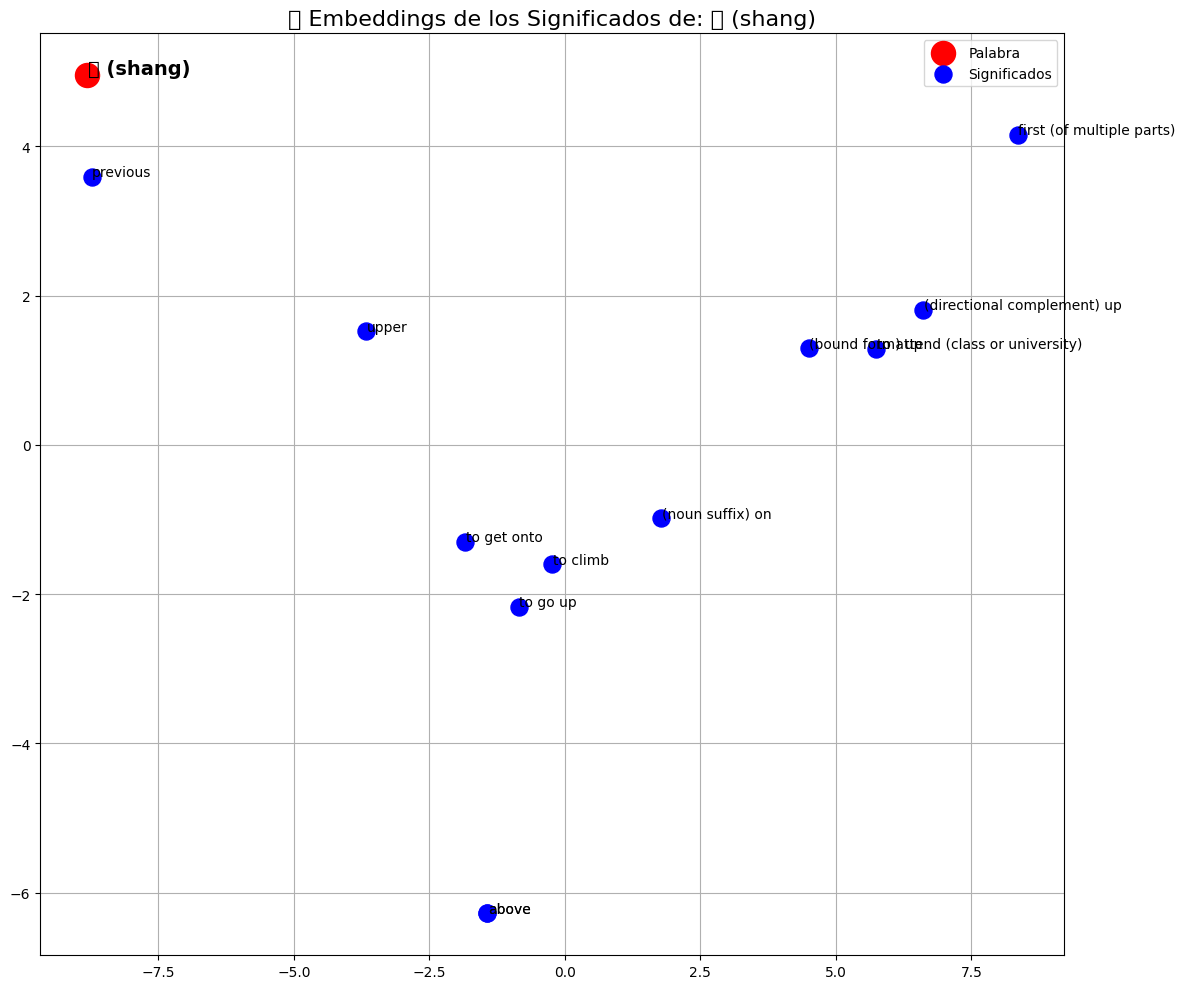

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Unimos el embedding de la palabra con los de sus significados
todos_vectores = [embedding_palabra] + embeddings_significados
coords = PCA(n_components=2).fit_transform(todos_vectores)

# Gráfico
plt.figure(figsize=(12, 10))
plt.title(f"📍 Embeddings de los Significados de: {palabra} ({fila['Pinyin']})", fontsize=16)
plt.grid(True)

# Punto central: la palabra en rojo
plt.scatter(coords[0, 0], coords[0, 1], color='red', s=300, label="Palabra")
plt.text(coords[0, 0] + 0.02, coords[0, 1] + 0.02, f"{palabra} ({fila['Pinyin']})", fontsize=14, fontweight="bold")

# Puntos satélite: significados
for i, significado in enumerate(significados):
    x, y = coords[i + 1]
    plt.scatter(x, y, color='blue', s=150)
    plt.text(x + 0.01, y + 0.01, significado, fontsize=10)

plt.legend(["Palabra", "Significados"], loc="best")
plt.tight_layout()
plt.show()

In [43]:
#clasificamos los significados por categoria
# Significados separados por punto y coma en tu CSV
significados = [
    "(bound form) up",
    "upper",
    "above",
    "previous",
    "first (of multiple parts)",
    "to climb",
    "to get onto",
    "to go up",
    "to attend (class or university)",
    "(directional complement) up",
    "(noun suffix) on",
    "above"
]

# Clasificación manual por categoría
categorias = [
    "dirección",       # up
    "posición",        # upper
    "posición",        # above
    "tiempo",          # previous
    "tiempo",          # first of multiple parts
    "acción",          # to climb
    "acción",          # to get onto
    "acción",          # to go up
    "actividad",       # to attend
    "dirección",       # complement up
    "gramática",       # noun suffix on
    "posición"         # above (de nuevo)
]

In [44]:
#asignamos colores por categoria
# Asignamos un color a cada categoría
colores_categoria = {
    "dirección": "blue",
    "posición": "green",
    "tiempo": "orange",
    "acción": "purple",
    "actividad": "teal",
    "gramática": "brown"
}

<ipython-input-45-1bdfc86a09f2>:27: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-45-1bdfc86a09f2>:27: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


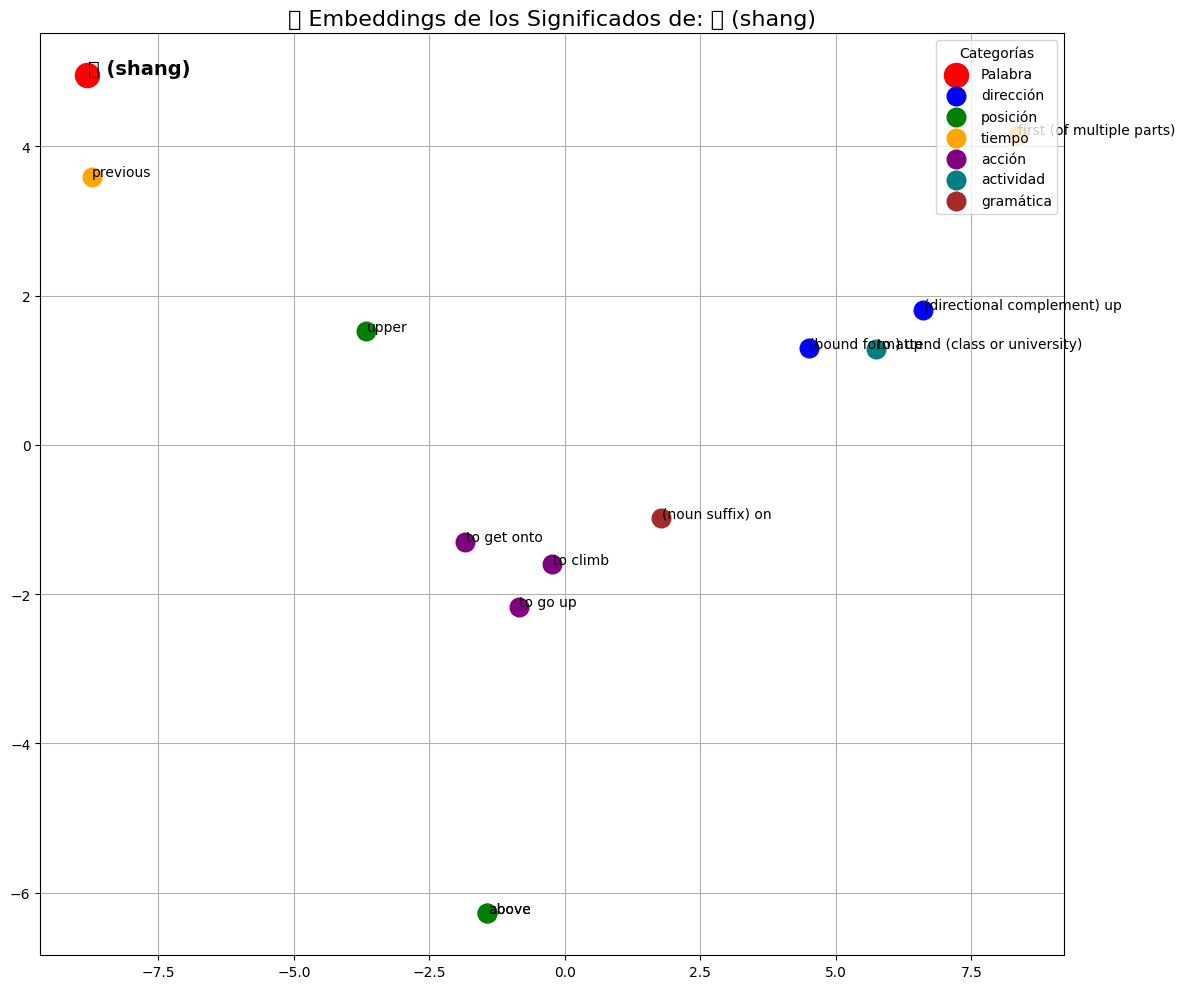

In [45]:
#visualizar por colores en grupo
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calculamos coordenadas PCA
todos_vectores = [obtener_embedding(palabra)] + [obtener_embedding(s) for s in significados]
coords = PCA(n_components=2).fit_transform(todos_vectores)

# Gráfico
plt.figure(figsize=(12, 10))
plt.title(f"📍 Embeddings de los Significados de: {palabra} ({fila['Pinyin']})", fontsize=16)
plt.grid(True)

# Punto central (la palabra china)
plt.scatter(coords[0, 0], coords[0, 1], color='red', s=300, label="Palabra")
plt.text(coords[0, 0] + 0.02, coords[0, 1] + 0.02, f"{palabra} ({fila['Pinyin']})", fontsize=14, fontweight="bold")

# Puntos de los significados, coloreados
for i, significado in enumerate(significados):
    categoria = categorias[i]
    color = colores_categoria[categoria]
    x, y = coords[i + 1]
    plt.scatter(x, y, color=color, s=180, label=categoria if categoria not in plt.gca().get_legend_handles_labels()[1] else None)
    plt.text(x + 0.01, y + 0.01, significado, fontsize=10)

plt.legend(title="Categorías", loc="upper right")
plt.tight_layout()
plt.show()

In [49]:
import pandas as pd
import re

# Lista para guardar cada fila como un dict
datos = []

with open("cedict.txt", encoding="utf-8") as f:
    for linea in f:
        if linea.startswith("#"):
            continue
        try:
            # Línea típica: 中國 中国 [Zhong1 guo2] /China/medio país/
            trad = re.match(r"(\S+)\s+(\S+)\s+\[(.+?)\]\s+/(.+)/", linea)
            if trad:
                palabra_simp = trad.group(1)
                palabra_trad = trad.group(2)
                pinyin = trad.group(3)
                significados = trad.group(4).split('/')

                if len(significados) > 1:
                    for significado in significados:
                        datos.append({
                            "palabra_china": palabra_simp,
                            "pinyin": pinyin,
                            "significado": significado.strip(),
                            "categoria": "",
                            "uso_tipico": ""
                        })
        except:
            continue

# Creamos el DataFrame con los significados separados
df = pd.DataFrame(datos)
df.head(100)


,palabra_china,pinyin,significado,categoria,uso_tipico
0,3C,san1 C,"computers, communications, and consumer electr...",,
1,3C,san1 C,China Compulsory Certificate (CCC),,
2,95後,jiu3 wu3 hou4,people born between 1995-01-01 and 1999-12-31,,
3,95後,jiu3 wu3 hou4,Gen Z (abbr. for 95後|95后 + 00後|00后),,
4,AB制,A B zhi4,to split the bill (where the male counterpart ...,,
...,...,...,...,...,...
95,䴉,huan2,ibis,,
96,䴉,huan2,family Threskiornithidae,,
97,一,yi1,one,,
98,一,yi1,single,,
